# Trabajo practico N° 5
## Alumno
- ### Bucca Matias.

## Implementación de un sistema de comunicaciones básico
El objetivo es aplicar los conceptos de Python, Verilog y Aritmética de Punto Fijo aplicados
en un sistema de comunicaciones básico.
## Ejercicio 1
Diseñar un sistema de comunicaciones básico que contenga los bloques PRBS9, filtro transmisor, diezmador con selección de fase óptima de muestreo, contador de Bit Error Rate y módulo de Control tal como se observa en la fig 1.<br>
* ### Características:
    * Modulación: QPSK
    * Frecuencia de Reloj: 100MHz
    * Over Sampling Factor: 4
    * Tipo de Filtro: Raised Cosine (6 baudios)
    * Roll Off: 0.5
    * Control: Controla el funcionamiento a diferentes velocidades de los módulos del sistema.
    * BER: El contador de BER debe realizar la etapa de inicialización cada vez que se cambia la fase de muestreo.
    * Seed PRBS9: PRBS9I (9’h1AA) - PRBS9Q (9’h1FE).


![fig 1](fig_1.png).

## Simulador de punto flotante

Diseñar en Python un simulador en punto flotante que contemple todo el diseño en donde la representación de la PRBS9 es una secuencia aleatoria y la estimación de la BER es una comparación vectores.<br>
1. Realizar los siguientes gráficos:
    * Bits transmitidos.
    * Respuesta al impulso y frecuencia del filtro Tx.
    * Salida y diagrama de ojo del filtro Tx.
    * Diagrama de constelaci´on a la salida del filtro Tx (por cada fase).

In [1]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from tool._fixedInt import *
## Parametros generales
T     = 1.0/10.0e9    # Periodo de baudio
Nsymb = 1000          # Numero de simbolos
os    = 4            # Over sampling
## Parametros de la respuesta en frecuencia
Nfreqs = 256          # Cantidad de frecuencias

## Parametros del filtro de caida cosenoidal
beta   = 0.5 # Roll-Off
Nbauds = 6.0          # Cantidad de baudios del filtro
## Parametros funcionales
Ts = T/os              # Frecuencia de muestreo

In [2]:
def rcosine(beta, Tbaud, oversampling, Nbauds, Norm):
    t_vect = np.arange(-0.5*Nbauds*Tbaud, 0.5*Nbauds*Tbaud,float(Tbaud)/oversampling)
    y_vect = []
    for t in t_vect:
        y_vect.append(np.sinc(t/Tbaud)*(np.cos(np.pi*beta*t/Tbaud)/(1-(4.0*beta*beta*t*t/(Tbaud*Tbaud)))))
    y_vect = np.array(y_vect)
    if(Norm):
        return (t_vect, y_vect/np.sqrt(np.sum(y_vect**2)))
    else:
        return (t_vect,y_vect)

In [48]:
(t,rc0) = rcosine(beta, T,os,Nbauds,Norm=False)
print(rc0)


[ 8.95103186e-34  4.77279499e-03  1.71488822e-02  2.27496429e-02
 -1.07232563e-16 -5.76127319e-02 -1.20042175e-01 -1.22501738e-01
  1.14816791e-15  2.62503724e-01  6.00210877e-01  8.87236072e-01
  1.00000000e+00  8.87236072e-01  6.00210877e-01  2.62503724e-01
 -2.06498656e-15 -1.22501738e-01 -1.20042175e-01 -5.76127319e-02
  5.99557366e-16  2.27496429e-02  1.71488822e-02  4.77279499e-03]


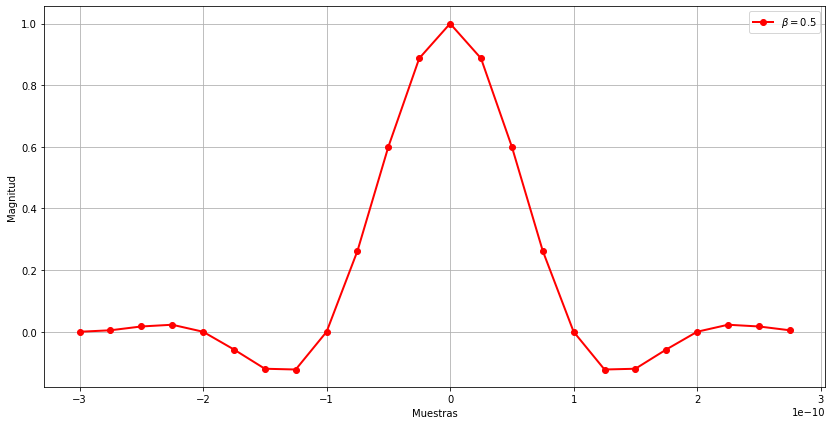

In [49]:
plt.figure(figsize=[14,7])
plt.plot(t,rc0,'ro-',linewidth=2.0,label=r'$\beta=0.5$')
plt.legend()
plt.grid(True)
#plt.xlim(0,len(rc0)-1)
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.show()

In [50]:
def resp_freq(filt, Ts, Nfreqs):
    #Computo de la respuesta en frecuencia de cualquier filtro FIR
    H = [] # Lista de salida de la magnitud
    A = [] # Lista de salida de la fase
    filt_len = len(filt)

    #### Genero el vector de frecuencias
    freqs = np.matrix(np.linspace(0,1.0/(2.0*Ts),Nfreqs))
    #### Calculo cuantas muestras necesito para 20 ciclo de
    #### la mas baja frec diferente de cero
    Lseq = 20.0/(freqs[0,1]*Ts)

    #### Genero el vector tiempo
    t = np.matrix(np.arange(0,Lseq))*Ts

    #### Genero la matriz de 2pifTn
    Omega = 2.0j*np.pi*(t.transpose()*freqs)

    #### Valuacion de la exponencial compleja en todo el
    #### rango de frecuencias
    fin = np.exp(Omega)

    #### Suma de convolucion con cada una de las exponenciales complejas
    for i in range(0,np.size(fin,1)):
        fout = np.convolve(np.squeeze(np.array(fin[:,i].transpose())),filt)
        mfout = abs(fout[filt_len:len(fout)-filt_len])
        afout = np.angle(fout[filt_len:len(fout)-filt_len])
        H.append(mfout.sum()/len(mfout))
        A.append(afout.sum()/len(afout))

    return [H,A,list(np.squeeze(np.array(freqs)))]

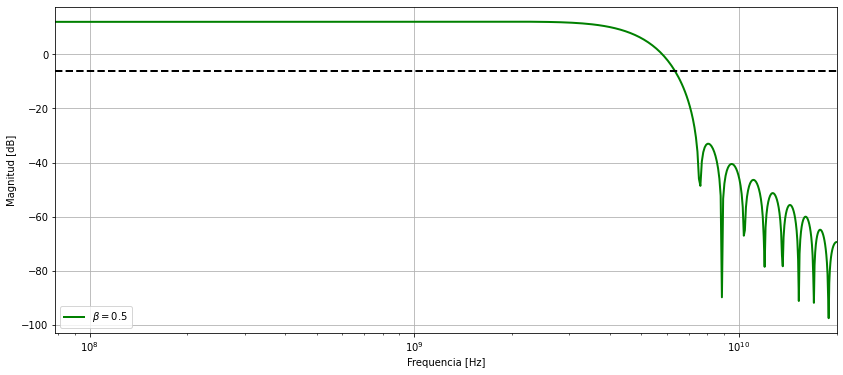

In [51]:
### Calculo respuesta en frec para los tres pulsos
[H0,A0,F0] = resp_freq(rc0, Ts, Nfreqs)

### Generacion de los graficos
plt.figure(figsize=[14,6])
plt.semilogx(F0, 20*np.log10(H0),'g', linewidth=2.0, label=r'$\beta=0.5$')

plt.axhline(y=20*np.log10(0.5),color='k',linestyle='--',linewidth=2.0)
plt.legend(loc=3)
plt.grid(True)
plt.xlim(F0[1],F0[len(F0)-1])
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.show()

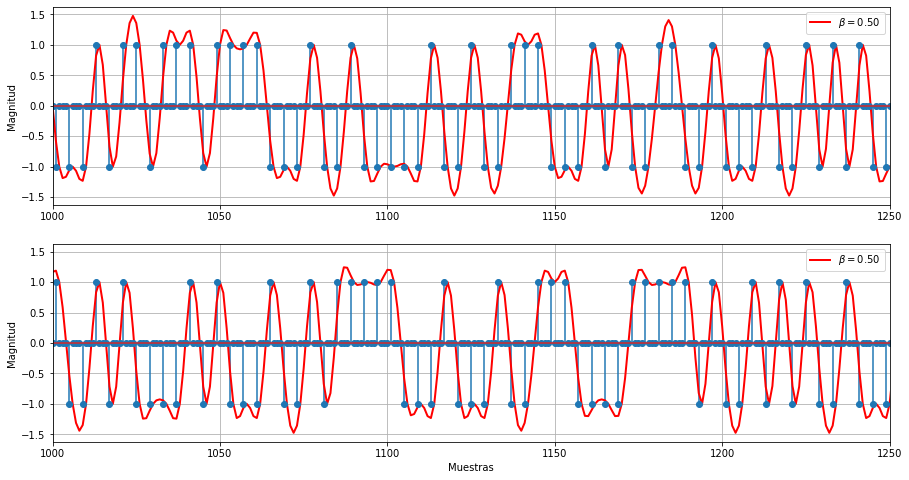

In [126]:
symbolsI = 2*(np.random.uniform(-1,1,Nsymb)>0.0)-1 
symbolsQ = 2*(np.random.uniform(-1,1,Nsymb)>0.0)-1
zsymbI = np.zeros(os*Nsymb); zsymbI[1:len(zsymbI):int(os)]=symbolsI
zsymbQ = np.zeros(os*Nsymb); zsymbQ[1:len(zsymbQ):int(os)]=symbolsQ

symb_out0I = np.convolve(rc0,zsymbI,'same'); 
symb_out0Q = np.convolve(rc0,zsymbQ,'same')
plt.figure(figsize=[15,8])
plt.subplot(2,1,1)
plt.plot(symb_out0I,'r-',linewidth=2.0,label=r'$\beta=%2.2f$'%beta)
plt.stem(zsymbI,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.ylabel('Magnitud')

plt.subplot(2,1,2)
plt.plot(symb_out0Q,'r-',linewidth=2.0,label=r'$\beta=%2.2f$'%beta)
plt.stem(zsymbQ,use_line_collection=True)
plt.xlim(1000,1250)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

plt.show()

Text(0.5, 1.0, 'rolloff 0.5')

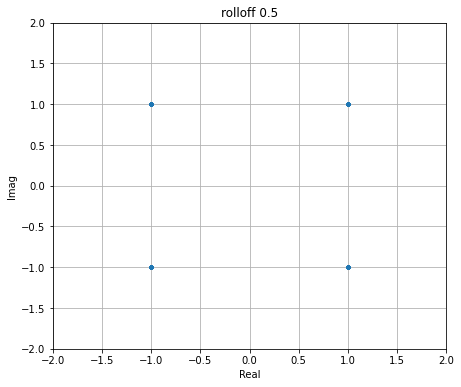

In [127]:
offset = 6

plt.figure(figsize=[6*4,6])
plt.subplot(1,3,1)
plt.plot(symb_out0I[100+offset:len(symb_out0I)-(100-offset):int(os)],
         symb_out0Q[100+offset:len(symb_out0Q)-(100-offset):int(os)],
             '.',linewidth=2.0)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.title("rolloff 0.5")


In [128]:
symb_out0I_dw=symb_out0I[1:len(zsymbI):int(os)]
symb_out0Q_dw=symb_out0Q[1:len(zsymbI):int(os)]

CBEI=0
CBEQ=0
for i in range(0,Nsymb):
    CBEI+= not round(symb_out0I_dw[i])==symbolsI[i]
    CBEQ+= not round(symb_out0I_dw[i])==symbolsI[i]
BERI=CBEI/Nsymb
BERQ=CBEQ/Nsymb
print("Cantidad de bit erroneos en el canal I: "+str(CBEI)+" BERI: " +str(BERI))
print("Cantidad de bit erroneos en el canal Q: "+str(CBEQ)+" BERI: " +str(BERQ))

Cantidad de bit erroneos en el canal I: 120 BERI: 0.12
Cantidad de bit erroneos en el canal Q: 120 BERI: 0.12


## Simulador de punto fijo
Partiendo del simulador anterior utilizar la librería fixedItnt.py.<br>
Definir las resoluciones de las diferentes etapas del diseño.
* Para el caso de la PRBS9 y el contador de BER aplicar el concepto de diseño de
hardware.
* Buscar una metodología de trabajo para simular los retardos del sistema.
* Utilizar el modelo para generar los archivos de est´ımulos para el Vector Matching
(VM).
* Realizar los siguientes gráficos
    * Bits transmitidos
    * Respuesta al impulso y frecuencia del filtro Tx.
    * Salida y diagrama de ojo del filtro Tx.
    * Diagrama de constelación a la salida del filtro Tx (por cada fase).


#### PRBS
Este módulo es un pseudo generador de numeros random cuya salida puede ser 1 o 0.

In [129]:
#module 
class PRBS():
    #(
    @property
    def parameter(self,N_PRBS=9,R_SEEDX=[1,1,0,0,0,1,0,1,1]):
        self.__R_SEEDX=R_SEEDX
        self.__N_PRBS=N_PRBS
    #)
    #(
    @property
    def o(self):
        self.__o_prbsX=self.__s_prbsX[self.__N_PRBS-1]
        return self.__o_prbsX
    def __init__(self,N_PRBS, SEEDX):
        self.__R_SEEDX=SEEDX
        self.__N_PRBS=N_PRBS
    def reset(self):
        self.__s_prbsX=self.__R_SEEDX
    def clock(self):
        self.__s_prbsX = np.concatenate([[self.__s_prbsX[self.__N_PRBS-5] ^ self.__s_prbsX[self.__N_PRBS-1]],
                                         self.__s_prbsX[0:self.__N_PRBS-1]])

PSRB test

In [163]:
PRBS_ord = 9
SEEDI=np.array([1,1,0,1,0,1,0,1,0])
SEEDQ=np.array([1,1,1,1,1,1,1,1,0])
N_sym=20
list_symbols=list()
u_PRBSI=PRBS(PRBS_ord, SEEDI)
u_PRBSI.reset()
for clock in range(N_sym):
    u_PRBSI.clock()
    symbolI=u_PRBSI.o
    list_symbols.append(symbolI)
print("Semilla I:",SEEDI)
print("Semilla Q:",SEEDQ)
print(list_symbols)

Semilla I: [1 1 0 1 0 1 0 1 0]
Semilla Q: [1 1 1 1 1 1 1 1 0]
[1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]


#### MAPPER
Este módulo se encarga de recibir la señal random generada y transformarla en +1 y -1. Esto evita que el canal de transmisión tenga un piso de continua.

In [164]:
class MAPPER():
    #(
    @property
    def o(self):
        self.__o_map=self.__s_map
        return self.__o_map
    @property
    def i(self):
        return self.__i_bit   
    @i.setter
    def i(self,i_bit):
        self.__i_bit=i_bit
    #)
    def __init__(self,i_bit=00):
        self.__i_bit=i_bit
        self.__s_map=DeFixedInt(2,0,'S','round','saturate')
    def reset(self):
        self.__s_map.value=0
    def clock(self):
        if(self.__i_bit):
            self.__s_map.value=1
        else:
            self.__s_map.value=-1


Mapper test:

In [165]:
u_mapper=MAPPER()
u_mapper.reset()
list_mapper=list()
for clock in range(N_sym):
    u_mapper.i=list_symbols[clock]
    u_mapper.clock()
    mapped=u_mapper.o
    list_mapper.append(mapped.fValue)
           
up_mapper_test = np.zeros(os*N_sym)
up_mapper_test[0:N_sym*os:int(os)]=list_mapper
print(list_mapper)

[1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0]


#### Filtro RC
Este módulo se encarga de recibir la señal digital y filtrarla para transformarla en analógica.

Text(0.5, 1.0, 'rolloff 0.0')

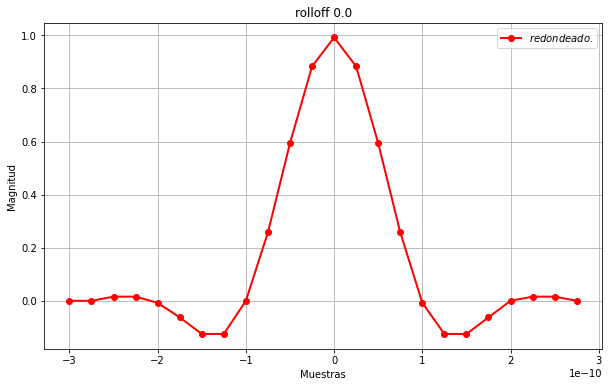

In [166]:
rc0_fix_coef=arrayFixedInt(8, 7,rc0 , signedMode='S', roundMode='trunc', saturateMode='saturate')
rc0_sxx_t=np.array([rc0_fix_coef[i].fValue for i in range(len(rc0_fix_coef))])
plt.figure(figsize=[10,6])
plt.plot(t,rc0_sxx_t,'ro-',linewidth=2.0,label=r'$redondeado.$')
plt.legend()
plt.grid(True)
plt.xlabel('Muestras')
plt.ylabel('Magnitud')
plt.title("rolloff 0.0")

In [167]:
rc0_fix_coef_v=""
for i in range(len(rc0_fix_coef)):
    rc0_fix_coef_v+=str("assign r_coef[")+str(i)+str("] = 8'b")+str(bin(rc0_fix_coef[i].intvalue))[2:].zfill(rc0_fix_coef[i].width)+str(";\n")
print(len(rc0_fix_coef_v)-1-(len("parameter COEF = 191'b")))
print(rc0_fix_coef_v)
f = open ('test_file/v_s_rc_filter.v','w')
f.write(rc0_fix_coef_v)
f.close()

759
assign r_coef[0] = 8'b00000000;
assign r_coef[1] = 8'b00000000;
assign r_coef[2] = 8'b00000010;
assign r_coef[3] = 8'b00000010;
assign r_coef[4] = 8'b11111111;
assign r_coef[5] = 8'b11111000;
assign r_coef[6] = 8'b11110000;
assign r_coef[7] = 8'b11110000;
assign r_coef[8] = 8'b00000000;
assign r_coef[9] = 8'b00100001;
assign r_coef[10] = 8'b01001100;
assign r_coef[11] = 8'b01110001;
assign r_coef[12] = 8'b01111111;
assign r_coef[13] = 8'b01110001;
assign r_coef[14] = 8'b01001100;
assign r_coef[15] = 8'b00100001;
assign r_coef[16] = 8'b11111111;
assign r_coef[17] = 8'b11110000;
assign r_coef[18] = 8'b11110000;
assign r_coef[19] = 8'b11111000;
assign r_coef[20] = 8'b00000000;
assign r_coef[21] = 8'b00000010;
assign r_coef[22] = 8'b00000010;
assign r_coef[23] = 8'b00000000;



0.0,-0.125,0.9921875,-0.125
0.0,-0.125,0.8828125,-0.0625
0.015625,0.0,0.59375,0.0
0.015625,0.2578125,0.2578125,0.015625
-0.0078125,0.59375,-0.0078125,0.015625
-0.0625,0.8828125,-0.125,0.0


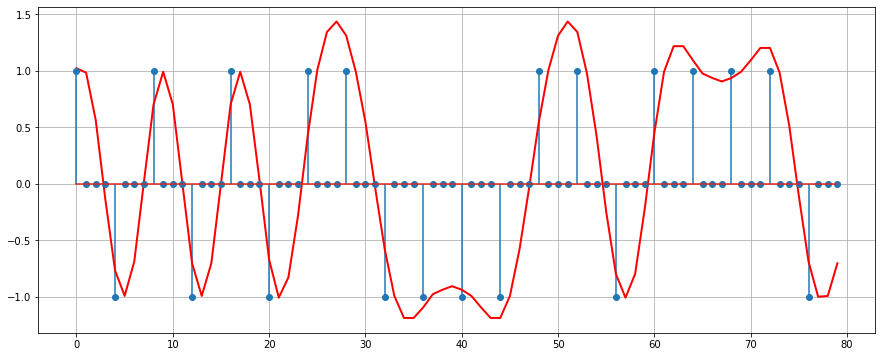

In [168]:
up_mapper_fx=arrayFixedInt(2,0,up_mapper_test,'S','trunc','saturate')
out_fx = np.convolve(rc0_fix_coef,up_mapper_fx,'same')
out_fx_v=np.array([out_fx[i].fValue for i in range(len(out_fx))])

plt.figure(figsize=[15,6])
plt.plot(out_fx_v,'r-',linewidth=2.0,label=r'$truncado$')
plt.stem(up_mapper_test,use_line_collection=True)
plt.grid(True)

s_COEF_0=rc0_fix_coef[0:len(rc0_fix_coef):6]
s_COEF_1=rc0_fix_coef[1:len(rc0_fix_coef):6]
s_COEF_2=rc0_fix_coef[2:len(rc0_fix_coef):6]
s_COEF_3=rc0_fix_coef[3:len(rc0_fix_coef):6]
s_COEF_4=rc0_fix_coef[4:len(rc0_fix_coef):6]
s_COEF_5=rc0_fix_coef[5:len(rc0_fix_coef):6]

#print(rc0_sxx_t)
print(str(s_COEF_0[0].fValue) +","+str(s_COEF_0[1].fValue) +","+str(s_COEF_0[2].fValue) +","+str(s_COEF_0[3].fValue))
print(str(s_COEF_1[0].fValue) +","+str(s_COEF_1[1].fValue) +","+str(s_COEF_1[2].fValue) +","+str(s_COEF_1[3].fValue))
print(str(s_COEF_2[0].fValue) +","+str(s_COEF_2[1].fValue) +","+str(s_COEF_2[2].fValue) +","+str(s_COEF_2[3].fValue))
print(str(s_COEF_3[0].fValue) +","+str(s_COEF_3[1].fValue) +","+str(s_COEF_3[2].fValue) +","+str(s_COEF_3[3].fValue))
print(str(s_COEF_4[0].fValue) +","+str(s_COEF_4[1].fValue) +","+str(s_COEF_4[2].fValue) +","+str(s_COEF_4[3].fValue))
print(str(s_COEF_5[0].fValue) +","+str(s_COEF_5[1].fValue) +","+str(s_COEF_5[2].fValue) +","+str(s_COEF_5[3].fValue))



In [169]:
class RC():
     #(
    @property
    def parameter(self,RC_COEF,Nbauds):
        self.___N_bauds=Nbauds
        self.__s_COEF_0=RC_COEF[0:4]
        self.__s_COEF_1=RC_COEF[4:8]
        self.__s_COEF_2=RC_COEF[8:12]
        self.__s_COEF_3=RC_COEF[12:16]
        self.__s_COEF_4=RC_COEF[16:20]
        self.__s_COEF_5=RC_COEF[20:24]
    @property
    def o(self):
        return self.__s_output
    @property
    def i(self):
        return self.__s_input 
    @property
    def r(self):
        return np.array([self.__r_input[i].fValue for i in range(len(self.__r_input))])
    @property
    def c(self):
        return self.__s_count
    @i.setter
    def i(self,i_bit):
        self.__s_input=i_bit
    #)
    def __init__(self,RC_COEF,Nbauds):
        self.___N_bauds=Nbauds
        self.__s_COEF_0=RC_COEF[0:4]
        self.__s_COEF_1=RC_COEF[4:8]
        self.__s_COEF_2=RC_COEF[8:12]
        self.__s_COEF_3=RC_COEF[12:16]
        self.__s_COEF_4=RC_COEF[16:20]
        self.__s_COEF_5=RC_COEF[20:24]
        self.__s_count=0
        N=np.zeros(Nbauds)
        self.__r_input=arrayFixedInt(2,0,N,'S','trunc','saturate')
        self.__s_output=DeFixedInt(10,7,'S','round','saturate')
    def reset(self):
        self.__s_count=0
        for i in range(len(self.__r_input)):
            self.__r_input[i].value=0
        self.__s_output.value=0
    def clock(self):
        if (self.__s_count==0):
            self.__r_input=np.concatenate([[self.__s_input],self.__r_input[0:self.___N_bauds-1]])     
        self.__s_output=((self.__r_input[0]*self.__s_COEF_5[3-self.__s_count])+
                         (self.__r_input[1]*self.__s_COEF_4[3-self.__s_count])+
                         (self.__r_input[2]*self.__s_COEF_3[3-self.__s_count])+
                         (self.__r_input[3]*self.__s_COEF_2[3-self.__s_count])+
                         (self.__r_input[4]*self.__s_COEF_1[3-self.__s_count])+
                         (self.__r_input[5]*self.__s_COEF_0[3-self.__s_count]))
        if (self.__s_count==3):
            self.__s_count=0
        else:
            self.__s_count+=1



### RC test

In [170]:
list_rcout=list()
rc_in=list()
list_data=arrayFixedInt(2,0,list_mapper,'S','trunc','saturate')
u_rc=RC(rc0_fix_coef,int(Nbauds))
N=np.zeros(1)
s_input=arrayFixedInt(2,0,N,'S','trunc','saturate')
u_rc.reset()

for i in range(len(list_data)):
    u_rc.i=list_data[i]
    for j in range(os):
        u_rc.clock()
        list_rcout.append(u_rc.o.fValue)


Text(0, 0.5, 'Magnitud')

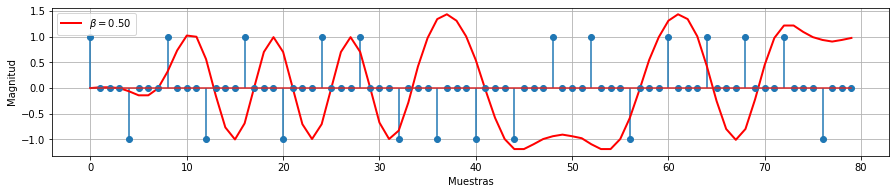

In [171]:
plt.figure(figsize=[15,6])
plt.subplot(2,1,1)
plt.plot(list_rcout,'r-',linewidth=2.0,label=r'$\beta=%2.2f$'%beta)
plt.stem(up_mapper_test,use_line_collection=True)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')


#### Sync.
Este módulo pone un 1 en su salida cuando detecta una señal que supere un umbral positivo y negativo.

In [172]:
class SYNC():
    #(
    @property
    def o(self):
        return self.__o_sync
    @property
    def i(self):
        return self.__i_adc   
    @i.setter
    def i(self,i_adc):
        self.__i_adc=i_adc
    #)
    def __init__(self):
        self.__i_adc =DeFixedInt(10,7,'S','round','saturate')
        self.__o_sync=0
    def reset(self):
        self.__i_adc.value=0
        self.__o_sync=0
    def clock(self):
        if((self.__i_adc.fValue<=-0.8) or (self.__i_adc.fValue>=0.8)):
            self.__o_sync=1
        


Test del detector de simbolos

In [173]:
list_sync=list()
i_bits=arrayFixedInt(10,7,list_rcout,'S','trunc','saturate')
u_sync=SYNC()
for i in range(len(i_bits)):
    u_sync.i=i_bits[i]
    u_sync.clock()
    list_sync.append(u_sync.o)

Text(0, 0.5, 'Magnitud')

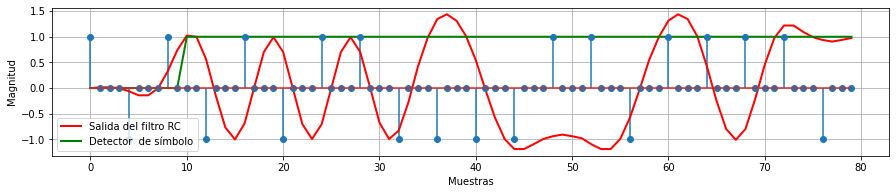

In [174]:
plt.figure(figsize=[15,6])
plt.subplot(2,1,1)
plt.plot(list_rcout,'r-',linewidth=2.0,label='Salida del filtro RC')
plt.plot(list_sync,'g-',linewidth=2.0,label='Detector  de símbolo')
plt.stem(up_mapper_test,use_line_collection=True)
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

#### Downsampler
Este módulo toma la señal recibida del filtro y la mantiene la cantidad de clocks correspondientes al oversampling.

In [175]:
class DWNSMP():
    #(
    @property
    def o(self):
        return self.__o_adc
    @property
    def i(self):
        return self.__i_adc   
    @i.setter
    def i(self,i_adc):
        self.__s_adc=i_adc
    @property
    def s(self):
        return self.__s_sync   
    @s.setter
    def s(self,i_sync):
        self.__s_sync=i_sync
    #)
    def __init__(self):
        self.__s_adc =DeFixedInt(10,7,'S','round','saturate')
        self.__s_sync=0 
        self.__s_count=0
        self.__o_adc =DeFixedInt(10,7,'S','round','saturate')
    def reset(self):
        self.__c_count=0
        self.__s_adc.value=0
        self.__o_adc.value=0
    def clock(self):
        if(self.__s_sync):
            if(self.__s_count==0):
                self.__o_adc=self.__s_adc
            if(self.__s_count==3):
                self.__s_count=0
            else:
                self.__s_count+=1
            


Downsampler test

In [176]:
i_bits=arrayFixedInt(10,7,list_rcout,'S','trunc','saturate')
u_dwnsmp=DWNSMP()
u_sync.reset()
list_dwnsmp=list()
list_sync=list()
for i in range(len(i_bits)):
    u_dwnsmp.i=i_bits[i]
    u_dwnsmp.s=u_sync.o
    u_sync.i=i_bits[i]
    u_sync.clock()
    u_dwnsmp.clock()
    list_dwnsmp.append(u_dwnsmp.o.fValue)
    list_sync.append(u_sync.o)

Text(0, 0.5, 'Magnitud')

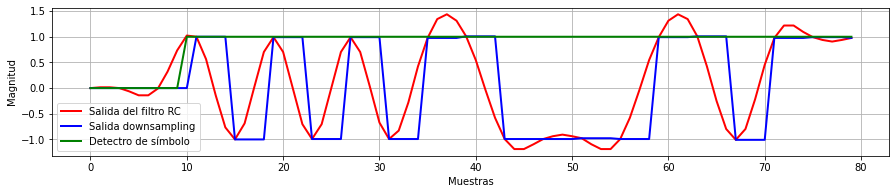

In [177]:
plt.figure(figsize=[15,6])
plt.subplot(2,1,1)
plt.plot(list_rcout,'r-',linewidth=2.0,label='Salida del filtro RC')
plt.plot(list_dwnsmp,'b-',linewidth=2.0,label='Salida downsampling')
plt.plot(list_sync,'g-',linewidth=2.0,label='Detectro de símbolo')
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

#### Slicer
Este módulo se encarga de transformar las señales positivas y negativas recibidas del adc en 0 y 1.

In [178]:
class SLICER():
    #(
    @property
    def o(self):
        return self.__o_symb
    @property
    def i(self):
        return self.__i_adc   
    @i.setter
    def i(self,i_adc):
        self.__i_adc=i_adc
    #)
    def __init__(self):
        self.__i_adc =DeFixedInt(10,7,'S','round','saturate')
        self.__o_symb=0
    def reset(self):
        self.__i_adc.value=0
        self.__o_symb
    def clock(self):
        if(self.__i_adc.fValue>0):
            self.__o_symb=1
        else:
            self.__o_symb=0

Slicer test

In [179]:
i_bits=arrayFixedInt(10,7,list_rcout,'S','trunc','saturate')
u_dwnsmp=DWNSMP()
u_slicer=SLICER()
u_sync.reset()
list_dwnsmp=list()
list_sync=list()
list_slicer=list()
for i in range(len(i_bits)):
    u_dwnsmp.i=i_bits[i]
    u_dwnsmp.s=u_sync.o
    u_slicer.i=u_dwnsmp.o
    u_sync.i=i_bits[i]
    u_sync.clock()
    u_dwnsmp.clock()
    u_slicer.clock()
    list_slicer.append(u_slicer.o)
    list_dwnsmp.append(u_dwnsmp.o.fValue)
    list_sync.append(u_sync.o)

Text(0, 0.5, 'Magnitud')

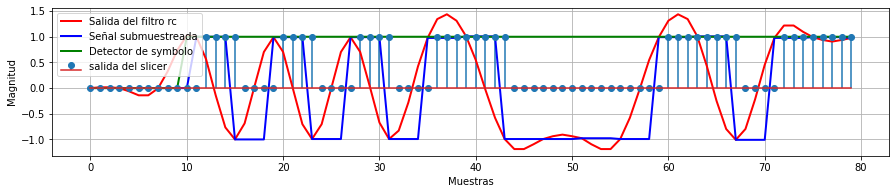

In [180]:
plt.figure(figsize=[15,6])
plt.subplot(2,1,1)
plt.plot(list_rcout,'r-',linewidth=2.0,label='Salida del filtro rc')
plt.plot(list_dwnsmp,'b-',linewidth=2.0,label='Señal submuestreada')
plt.plot(list_sync,'g-',linewidth=2.0,label='Detector de symbolo')
plt.stem(list_slicer,use_line_collection=True,label='salida del slicer')
plt.grid(True)
plt.legend()
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

#### BER
Este módulo cumple la función de comparar las señales generadas con las recibidas. 

In [181]:
class BER():
    #(
    @property
    def o_sym(self):
        return self.__o_symb
    @property
    def o_ref(self):
        return self.__o_ref
    @property
    def i_ref(self):
        return self.__i_ref   
    @i_ref.setter
    def i_ref(self,i_bit):
        self.__i_ref=i_bit
    @property
    def i_slicer(self):
        return self.__i_slicer 
    @i_slicer.setter
    def i_slicer(self,i_bit):
        self.__i_slicer=i_bit     
    @property
    def i_sync(self,i_bit):
        return self.__i_sync  
    @i_sync.setter
    def i_sync(self,i_bit):
        self.__i_sync=i_bit
    #)
    def __init__(self):
        self.__i_slicer =0
        self.__i_sync =0
        self.__i_ref  =0
        self.__o_symb =0
        self.__o_ref =0
        self.__s_count=0
        self.__s_lat=0
        self.__s_err=0
        self.__s_bufer=np.zeros(20)
    def reset(self):
        self.__i_slicer =0
        self.__i_sync =0
        self.__i_ref  =0
        self.__o_symb =0
        self.__o_ref =0
        self.__s_count=0
        self.__s_err
        self.__s_lat=0
    def clock(self):
        self.__s_bufer=np.concatenate([[self.__i_ref],self.__s_bufer[0:19]])
        if(self.__i_sync):
            if(self.__s_count<3):
                self.__s_count+=1
                self.__s_lat+=1
        else:
            self.__s_lat+=1
        if(self.__s_count==3):
            self.__o_symb=self.__i_slicer
            self.__o_ref=self.__s_bufer[self.__s_lat-1]
            if(not(self.__s_bufer[self.__s_lat-1]==self.__i_slicer)):
                if(self.__s_err==100):
                    self.__s_err=100
                else:
                    self.__s_err+=1


### Simulación completa.

In [182]:
N_sym=20
list_symbols=list()
list_mapper=list()
list_rcout=list()
list_rcreg=list()
list_sync=list()
list_dwnsmp=list()
list_slicer=list()
list_ber_sym=list()
list_ber_ref=list()

u_PRBS=PRBS(PRBS_ord, SEEDI)
u_MAPPER=MAPPER()
u_RC=RC(rc0_fix_coef,int(Nbauds))
u_SYNC=SYNC()
u_DWNSMP=DWNSMP()
u_SLICER=SLICER()
u_BER=BER()

u_PRBS.reset()
u_MAPPER.reset()
u_RC.reset()
u_SYNC.reset()
u_DWNSMP.reset()
u_SLICER.reset()
u_BER.reset()

N=np.zeros(N_sym)
o_mapper=arrayFixedInt(2,0,N,'S','round','saturate')
for i in range(N_sym):
    u_MAPPER.i=u_PRBS.o
    o_mapper[i].value=u_MAPPER.o.fValue
    u_RC.i=o_mapper[i]
    u_SYNC.i=u_RC.o
    u_DWNSMP.i=u_RC.o
    u_DWNSMP.s=u_SYNC.o
    u_SLICER.i=u_DWNSMP.o
    u_BER.i_ref=u_PRBS.o
    u_BER.i_slicer=u_SLICER.o
    u_BER.i_sync=u_SYNC.o

    u_SLICER.clock()
    u_DWNSMP.clock()
    u_SYNC.clock()
    u_RC.clock()
    u_MAPPER.clock()
    u_PRBS.clock()
    u_BER.clock()

    list_symbols.append(u_PRBS.o)
    list_mapper.append(u_MAPPER.o.fValue)
    list_rcout.append(u_RC.o.fValue)
    list_sync.append(u_SYNC.o)
    list_dwnsmp.append(u_DWNSMP.o.fValue)
    list_slicer.append(u_SLICER.o)
    list_ber_sym.append(u_BER.o_sym)
    list_ber_ref.append(u_BER.o_ref)
    list_rcreg.append(u_RC.i.fValue)
    for j in range(3):
            u_SYNC.i=u_RC.o
            u_DWNSMP.s=u_SYNC.o
            u_DWNSMP.i=u_RC.o

            u_DWNSMP.clock()
            u_SYNC.clock()
            u_RC.clock()
            list_rcout.append(u_RC.o.fValue)
            list_sync.append(u_SYNC.o)
            list_dwnsmp.append(u_DWNSMP.o.fValue)

y=np.zeros(N_sym)
x=list()
for i in range(0,N_sym*os,os):
    x.append(i)


Text(0, 0.5, 'Magnitud')

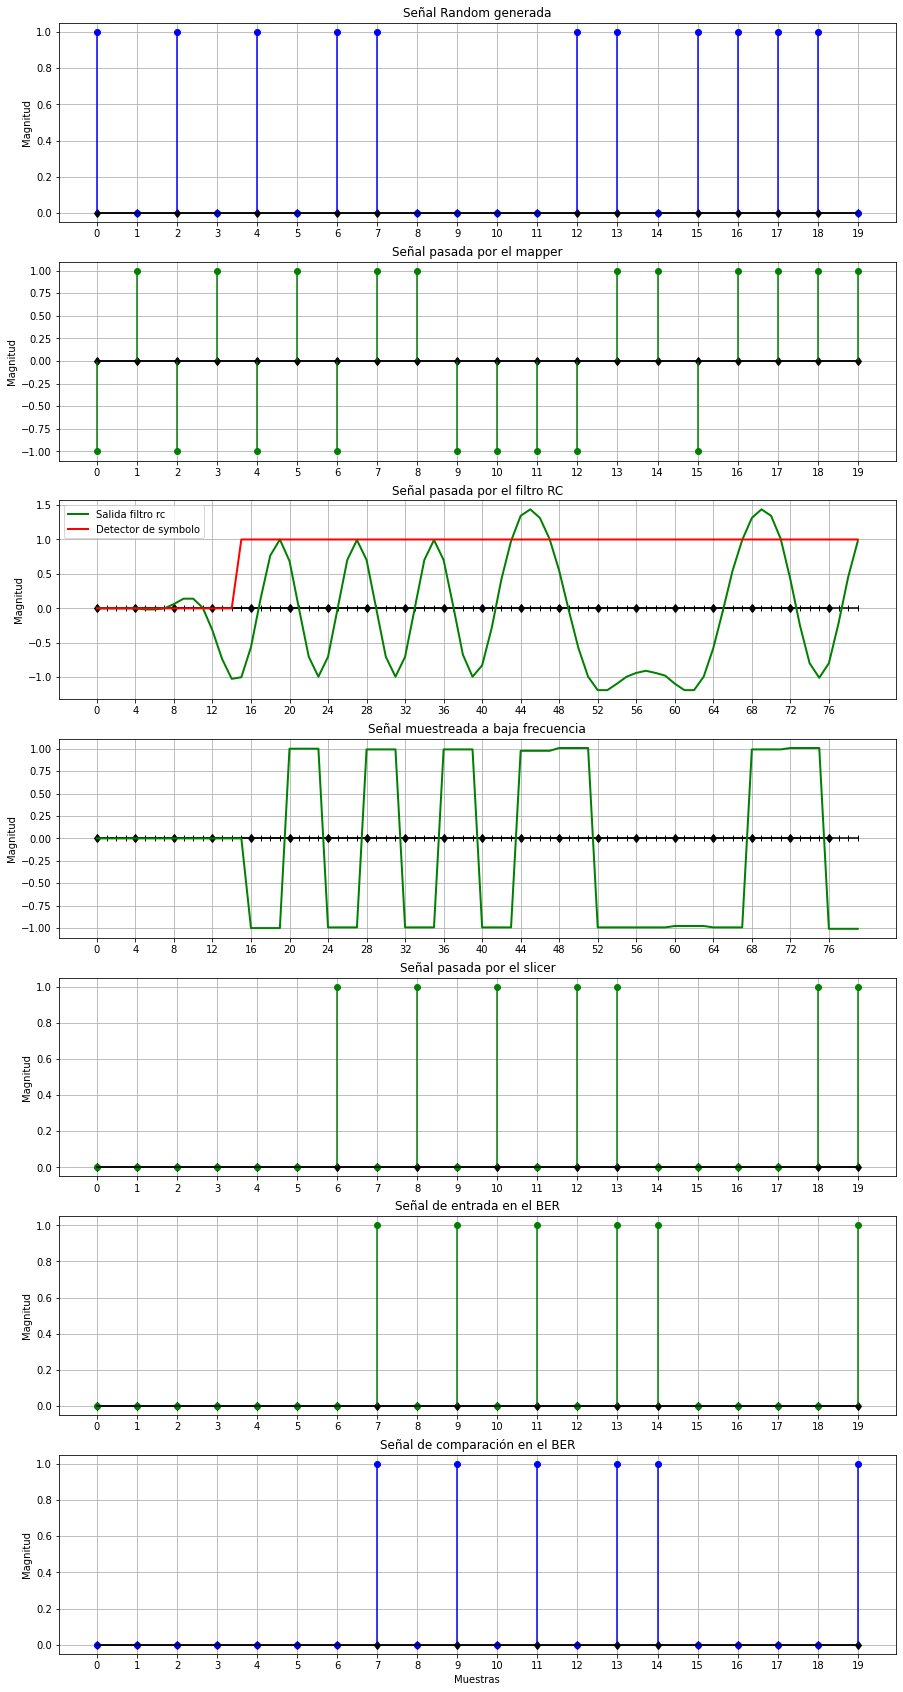

In [183]:
samples=np.zeros(N_sym*os)
ticks = np.arange(0,N_sym)
up_ticks = np.arange(0,N_sym*os,os)
plt.figure(figsize=[15,30])
plt.subplot(7,1,1)
plt.stem(range(0,len(list_slicer)),y[0:len(list_slicer)],linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.stem(list_symbols,linefmt='b-',markerfmt='bo',basefmt='k',use_line_collection=False)
plt.grid(True)
plt.xticks(ticks)
plt.ylabel('Magnitud')
plt.title("Señal Random generada")

plt.subplot(7,1,2)
plt.stem(range(0,len(list_slicer)),y[0:len(list_slicer)],linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.stem(list_mapper,linefmt='g-',markerfmt='go',basefmt='k',use_line_collection=False)
plt.title("Señal pasada por el mapper")
plt.xticks(ticks)
plt.grid(True)
plt.ylabel('Magnitud')

plt.subplot(7,1,3)
plt.stem(samples,linefmt='b-',markerfmt='k|',basefmt='k',use_line_collection=False)
plt.stem(x,y,linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.plot(list_rcout,'g-',linewidth=2.0,label='Salida filtro rc')
plt.plot(list_sync,'r-',linewidth=2.0,label='Detector de symbolo')
plt.title("Señal pasada por el filtro RC")
plt.xticks(up_ticks)
plt.grid(True)
plt.ylabel('Magnitud')
plt.legend()

plt.subplot(7,1,4)
plt.stem(samples,linefmt='b-',markerfmt='k|',basefmt='k',use_line_collection=False)
plt.stem(x,y,linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.plot(list_dwnsmp,'g-',linewidth=2.0)
plt.title("Señal muestreada a baja frecuencia")
plt.xticks(up_ticks)
plt.grid(True)
plt.ylabel('Magnitud')

plt.subplot(7,1,5)
plt.stem(range(0,len(list_slicer)),y[0:len(list_slicer)],linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.stem(list_slicer,linefmt='g-',markerfmt='go',basefmt='k',use_line_collection=False)
plt.title("Señal pasada por el slicer")
plt.xticks(ticks)
plt.grid(True)
plt.ylabel('Magnitud')

plt.subplot(7,1,6)
plt.stem(range(0,len(list_slicer)),y[0:len(list_slicer)],linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.stem(list_ber_sym,linefmt='g-',markerfmt='go',basefmt='k',use_line_collection=False)
plt.title("Señal de entrada en el BER")
plt.xticks(ticks)
plt.grid(True)
plt.ylabel('Magnitud')

plt.subplot(7,1,7)
plt.stem(range(0,len(list_slicer)),y[0:len(list_slicer)],linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.stem(list_ber_ref,linefmt='b-',markerfmt='bo',basefmt='k',use_line_collection=False)
plt.title("Señal de comparación en el BER")
plt.xticks(ticks)
plt.grid(True)
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

### Vector matching.
En esta sección se compara la simulación generada en python con la salidaque genera la descripción en verilog.

#### Modulo Prbs 

In [184]:
path='test_file/'

archivo   = open(path+"v_o_prbsx.txt", 'r')
v_aux = archivo.read().split('\n')
archivo.close()
v_o_prbsx=list()
for i in range(len(v_aux)):
    if v_aux[i]== '1':
        v_o_prbsx.append(1)
    else:
        v_o_prbsx.append(0)
print(v_o_prbsx)

[1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0]


Text(0.5, 1.0, 'Señal Random generada en verilog.')

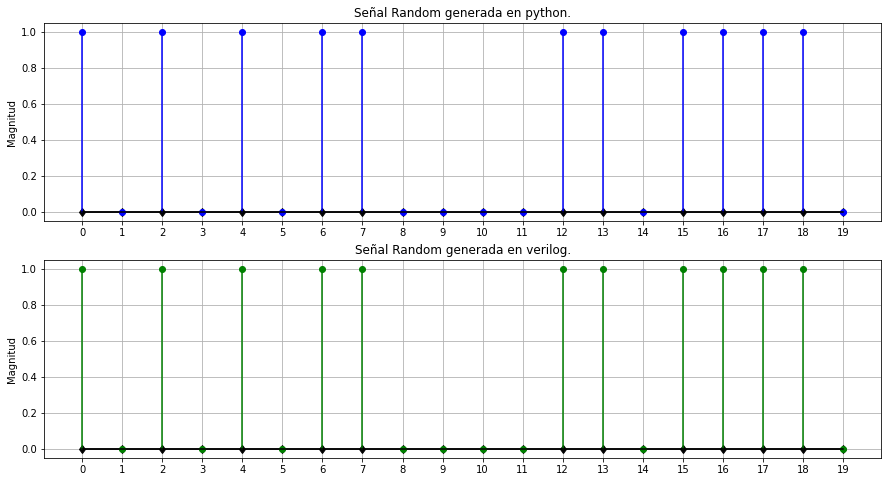

In [185]:
samples=np.zeros(N_sym*os)
ticks = np.arange(0,N_sym)
up_ticks = np.arange(0,N_sym*os,os)
plt.figure(figsize=[15,8])
plt.subplot(2,1,1)
plt.stem(range(0,len(list_slicer)),y[0:len(list_slicer)],linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.stem(list_symbols,linefmt='b-',markerfmt='bo',basefmt='k',use_line_collection=False)
plt.grid(True)
plt.xticks(ticks)
plt.ylabel('Magnitud')
plt.title("Señal Random generada en python.")

plt.subplot(2,1,2)
plt.stem(range(0,len(list_slicer)),y[0:len(list_slicer)],linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.stem(v_o_prbsx[0:N_sym],linefmt='g-',markerfmt='go',basefmt='k',use_line_collection=False)
plt.grid(True)
plt.xticks(ticks)
plt.ylabel('Magnitud')
plt.title("Señal Random generada en verilog.")


#### Modulo Mapper

In [186]:
archivo   = open(path+"v_o_mapperx.txt", 'r')
v_aux = archivo.read().split('\n')
archivo.close()
v_o_mapperx=list()
for i in range(len(v_aux)):
    if v_aux[i]== '01':
        v_o_mapperx.append(1.0)
    else:
        v_o_mapperx.append(-1.0)


Text(0, 0.5, 'Magnitud')

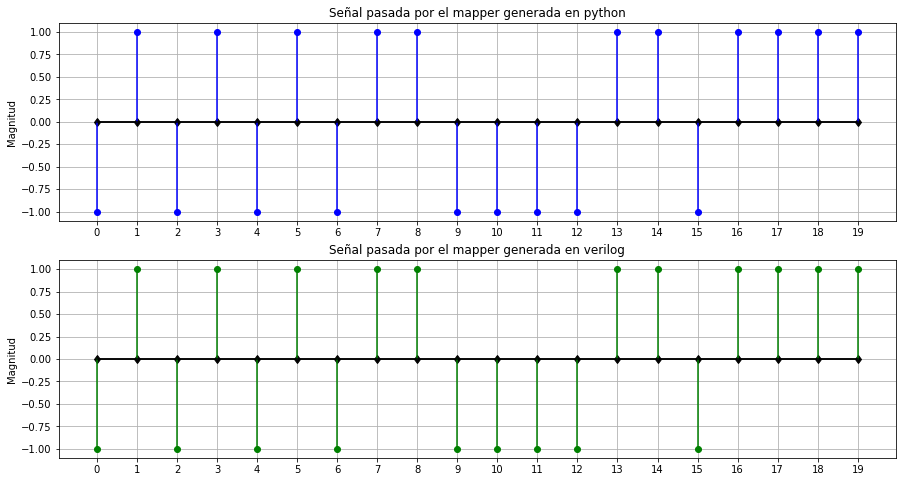

In [187]:
plt.figure(figsize=[15,8])
plt.subplot(2,1,1)
plt.stem(range(0,len(list_slicer)),y[0:len(list_slicer)],linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.stem(list_mapper,linefmt='b-',markerfmt='bo',basefmt='k',use_line_collection=False)
plt.title("Señal pasada por el mapper generada en python")
plt.xticks(ticks)
plt.grid(True)
plt.ylabel('Magnitud')

plt.subplot(2,1,2)
plt.stem(range(0,len(list_slicer)),y[0:len(list_slicer)],linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.stem(v_o_mapperx,linefmt='g-',markerfmt='go',basefmt='k',use_line_collection=False)
plt.title("Señal pasada por el mapper generada en verilog")
plt.xticks(ticks)
plt.grid(True)
plt.ylabel('Magnitud')

#### Módulo filtro RC
El filtro implementado en verilog dió como resultado el siguiente esquematico:

In [188]:
archivo   = open(path+"v_o_rc_filter.txt", 'r')
v_aux = archivo.read().split('\n')
archivo.close()
rc_filter=DeFixedInt(10,7,'S','round','wrap')
v_o_rc_filter=list()
for i in range(len(v_aux)-1):
    rc_filter.value=int(v_aux[i],2)
    v_o_rc_filter.append(rc_filter.fValue)

archivo   = open(path+"v_o_sync.txt", 'r')
v_aux = archivo.read().split('\n')
archivo.close()
v_o_sync=list()
for i in range(len(v_aux)-1):
    if v_aux[i]== '1':
        v_o_sync.append(1)
    else:
        v_o_sync.append(0)


![fig 1](filtro.png)

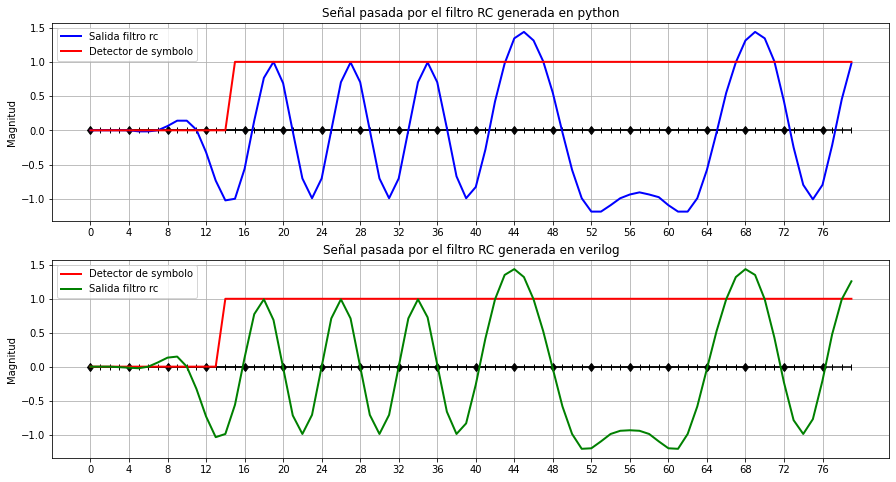

In [189]:
plt.figure(figsize=[15,8])
plt.subplot(2,1,1)
plt.stem(samples,linefmt='b-',markerfmt='k|',basefmt='k',use_line_collection=False)
plt.stem(x,y,linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.plot(list_rcout,'b-',linewidth=2.0,label='Salida filtro rc')
plt.plot(list_sync,'r-',linewidth=2.0,label='Detector de symbolo')
plt.title("Señal pasada por el filtro RC generada en python")
plt.xticks(up_ticks)
plt.grid(True)
plt.ylabel('Magnitud')
plt.legend()

plt.subplot(2,1,2)
plt.stem(samples,linefmt='b-',markerfmt='k|',basefmt='k',use_line_collection=False)
plt.stem(x,y,linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.plot(v_o_sync,'r-',linewidth=2.0,label='Detector de symbolo')
plt.plot(v_o_rc_filter,'g-',linewidth=2.0,label='Salida filtro rc')
plt.title("Señal pasada por el filtro RC generada en verilog")
plt.xticks(up_ticks)
plt.grid(True)
plt.ylabel('Magnitud')
plt.legend()

#### Modulo Downsamppler

In [190]:
archivo   = open(path+"v_o_dwnsmp.txt", 'r')
v_aux = archivo.read().split('\n')
archivo.close()
o_dwnsmp=DeFixedInt(10,7,'S','round','wrap')
v_o_dwnsmp=list()
for i in range(len(v_aux)-1):
    o_dwnsmp.value=int(v_aux[i],2)
    v_o_dwnsmp.append(o_dwnsmp.fValue)


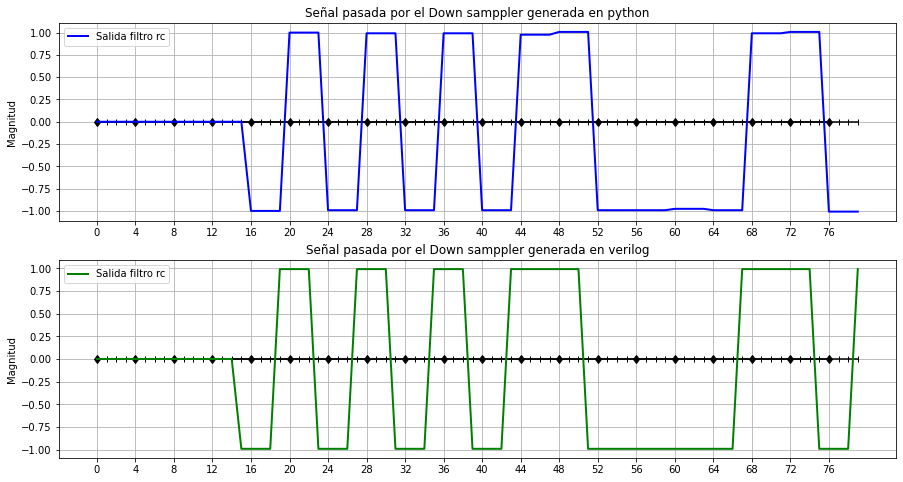

In [191]:
plt.figure(figsize=[15,8])
plt.subplot(2,1,1)
plt.stem(samples,linefmt='b-',markerfmt='k|',basefmt='k',use_line_collection=False)
plt.stem(x,y,linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.plot(list_dwnsmp,'b-',linewidth=2.0,label='Salida filtro rc')
plt.title("Señal pasada por el Down samppler generada en python")
plt.xticks(up_ticks)
plt.grid(True)
plt.ylabel('Magnitud')
plt.legend()

plt.subplot(2,1,2)
plt.stem(samples,linefmt='b-',markerfmt='k|',basefmt='k',use_line_collection=False)
plt.stem(x,y,linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.plot(v_o_dwnsmp,'g-',linewidth=2.0,label='Salida filtro rc')
plt.title("Señal pasada por el Down samppler generada en verilog")
plt.xticks(up_ticks)
plt.grid(True)
plt.ylabel('Magnitud')
plt.legend()

#### Módulo Slicer

In [192]:
path='test_file/'

archivo   = open(path+"v_o_slicer.txt", 'r')
v_aux = archivo.read().split('\n')
archivo.close()
v_o_prbsx=list()
v_o_prbsx.append(0)
for i in range(len(v_aux)-1):
    if v_aux[i]== '1':
        v_o_prbsx.append(1)
    else:
        v_o_prbsx.append(0)
print(v_o_prbsx)

[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0]


Text(0, 0.5, 'Magnitud')

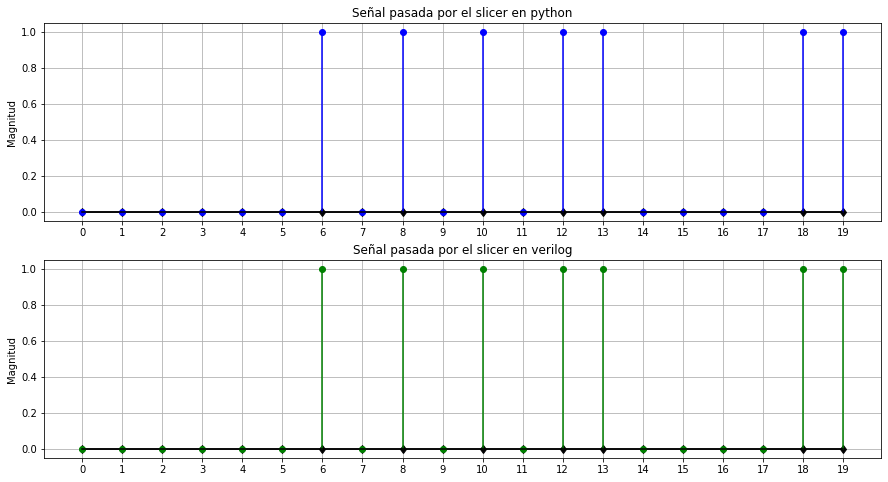

In [193]:
plt.figure(figsize=[15,8])
plt.subplot(2,1,1)
plt.stem(range(0,len(list_slicer)),y[0:len(list_slicer)],linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.stem(list_slicer,linefmt='b-',markerfmt='bo',basefmt='k',use_line_collection=False)
plt.title("Señal pasada por el slicer en python")
plt.xticks(ticks)
plt.grid(True)
plt.ylabel('Magnitud')
plt.subplot(2,1,2)
plt.stem(range(0,len(list_slicer)),y[0:len(list_slicer)],linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.stem(v_o_prbsx[0:len(v_o_prbsx)-1],linefmt='g-',markerfmt='go',basefmt='k',use_line_collection=False)
plt.title("Señal pasada por el slicer en verilog")
plt.xticks(ticks)
plt.grid(True)
plt.ylabel('Magnitud')

In [194]:
path='test_file/'

archivo   = open(path+"v_o_ber_prbs.txt", 'r')
v_aux = archivo.read().split('\n')
archivo.close()
v_o_ber_prbs=list()
for i in range(len(v_aux)-1):
    if v_aux[i]== '1':
        v_o_ber_prbs.append(1)
    else:
        v_o_ber_prbs.append(0)
print(v_o_ber_prbs)

archivo   = open(path+"v_o_ber_slicer.txt", 'r')
v_aux = archivo.read().split('\n')
archivo.close()
v_o_ber_slicer=list()
for i in range(len(v_aux)-1):
    if v_aux[i]== '1':
        v_o_ber_slicer.append(1)
    else:
        v_o_ber_slicer.append(0)
print(v_o_ber_slicer)
archivo   = open(path+"v_o_ber.txt", 'r')
v_aux = archivo.read().split('\n')
archivo.close()
v_o_ber=list()
for i in range(len(v_aux)-1):
    if v_aux[i]== '1':
        v_o_ber.append(1)
    else:
        v_o_ber.append(0)
print(v_o_ber)


[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1]
[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1]
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Text(0, 0.5, 'Magnitud')

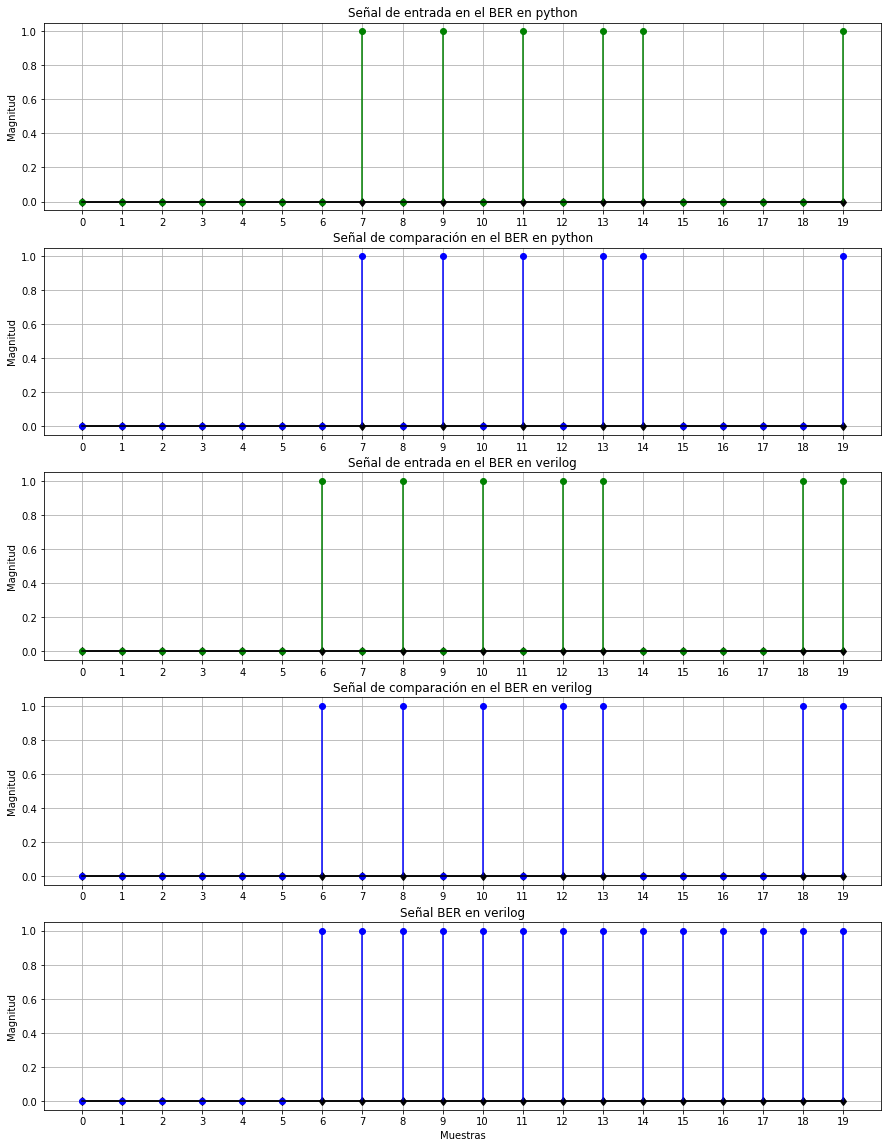

In [195]:
plt.figure(figsize=[15,20])
plt.subplot(5,1,1)
plt.stem(range(0,len(list_slicer)),y[0:len(list_slicer)],linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.stem(list_ber_sym,linefmt='g-',markerfmt='go',basefmt='k',use_line_collection=False)
plt.title("Señal de entrada en el BER en python")
plt.xticks(ticks)
plt.grid(True)
plt.ylabel('Magnitud')
plt.subplot(5,1,2)
plt.stem(range(0,len(list_slicer)),y[0:len(list_slicer)],linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.stem(list_ber_ref,linefmt='b-',markerfmt='bo',basefmt='k',use_line_collection=False)
plt.title("Señal de comparación en el BER en python")
plt.xticks(ticks)
plt.grid(True)
plt.ylabel('Magnitud')
plt.subplot(5,1,3)
plt.stem(range(0,len(list_slicer)),y[0:len(list_slicer)],linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.stem(v_o_ber_slicer,linefmt='g-',markerfmt='go',basefmt='k',use_line_collection=False)
plt.title("Señal de entrada en el BER en verilog")
plt.xticks(ticks)
plt.grid(True)
plt.ylabel('Magnitud')

plt.subplot(5,1,4)
plt.stem(range(0,len(list_slicer)),y[0:len(list_slicer)],linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.stem(v_o_ber_prbs,linefmt='b-',markerfmt='bo',basefmt='k',use_line_collection=False)
plt.title("Señal de comparación en el BER en verilog")
plt.xticks(ticks)
plt.grid(True)

plt.ylabel('Magnitud')
plt.subplot(5,1,5)
plt.stem(range(0,len(list_slicer)),y[0:len(list_slicer)],linefmt='b-',markerfmt='kd',basefmt='k',use_line_collection=False)
plt.stem(v_o_ber,linefmt='b-',markerfmt='bo',basefmt='k',use_line_collection=False)
plt.title("Señal BER en verilog")
plt.xticks(ticks)
plt.grid(True)
plt.xlabel('Muestras')
plt.ylabel('Magnitud')

## Resultados.
Finalmente todo el circuito implementado quedó del siguiente modo:

![fig 1](circuito_implementado.png)

En el cual las señales que actuaron en el circuito fueron:

![fig 1](simu_final.png)

Si se compara con la respuesta obtenida en la simulación hecha en python se puede ver que las señales obtenidas fueron las mismas y en instantes de tiempos bastantes proximos.